ChEn-5310: Computational Continuum Transport Phenomena Fall 2021 UMass Lowell; Prof. V. F. de Almeida **16Oct21**

# 05b. Rayleigh-Ritz Lagrange Finite Element Method Verification
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\fvec}{\boldsymbol{\mathsf{f}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Reals}{\mathbb{R}}
  \newcommand{\thetavec}{\boldsymbol{\theta}}
  \newcommand{\Ecal}{\mathcal{E}}
$

---

## Table of Contents<a id="toc"></a>
* [Objectives](#obj)
1. [Poisson Problem with Dirichlet Boundary Conditions](#problem)
1. [Manufactured Solution](#manufactured-solution)
   + [Data](#data)
   + [Manufactured Function](#manufactured-function)
   + [Manufactured Source](#manufactured-source)
1. [Rayleigh-Ritz Method w/ Lagrange Finite Element Basis Functions](#rayleigh-ritz-fem)
   + [Lift function](#lift-function)
   + [Finite Element Lagrange Basis Functions](#fem-lagrange-basis-inhomogeneous)
   + [FEM Solution](#results)
---

## [Objectives](#toc)<a id="obj"></a>

 + Describe the method of manufactured solutions for verification.
 + Use the function approximation theory described in the course (see previous notebooks and notes) to build manufactured solutions.
 + Evaluate the error of the Rayleigh-Ritz method for solving linear differential equations with symmetric positive definite operators ([OneNote notes: rayleigh-ritz-method](https://studentuml-my.sharepoint.com/:o:/g/personal/valmor_dealmeida_uml_edu/EsTzIb2Mcv5OkcSk0kSXXF8BXM4OnlzGfAd7sdcWLky-Gw?e=nglTrN).
 + Apply the finite element Lagrange basis function approach.

## [Poisson Problem with Dirichlet Boundary Conditions](#toc)<a id="problem"></a>

The following sections describe what is referred to in the literature as the one-dimensional Poisson problem with Dirichlet boundary conditions. This is a classical boundary-value problem of mathematics.

Solve the Poisson model problem. Find $u:[a,b]\subset\Reals\rightarrow\Reals$ such that:

\begin{align*}
 -\bigl(-D(x)\, u'\bigr)'(x) + S(x)\,u(x) + f(x) &= 0 \quad\quad \forall \quad\quad x\in [a,b], \\
 u(a) &= u_a, \\
 u(b) &= u_b.
\end{align*}
   
This problem is linear and has an analytical solution for given data: diffusion coefficient, $D(x)$, source, $S(x)$ slope, source bias, $f(x)$. The *diffusion flux* associated to the quantity $u$, is denoted $q := -D(x)\,u'$, and it is often of interest as a derived quantity.

The values of the dependent variable are given on the two end points of the domain. This is called *essential* boundary conditions or  *Dirichlet boundary conditions*. If the values are equal to zero, the boundary condition is referred to as homogeneous.

## [Manufactured Solution](#toc)<a id="manufactured-solution"></a>

Give the scaffolding below, build a manufactured solution by computing the corresponding source function.

### [Data](#toc)<a id="data"></a>

Solve problem with parameter values:

> + a = 0 cm
> + b = 25 cm
> + $u_a$ = given below g/cc
> + $u_b$ = given below g/cc
> + D = given below cm^2/s
> + S = given below  $s^{-1}$
> + f(x) = manufactured below g/cc-s

In [1]:
'''Domain'''

x_a = 0
x_b = 25

In [2]:
'''Parameters and data'''

diff_coeff = 0.1
source_slope_value = -0e-2

u_a_0 = 3.5  # initial value
u_b_0 = 3.5  # initial value

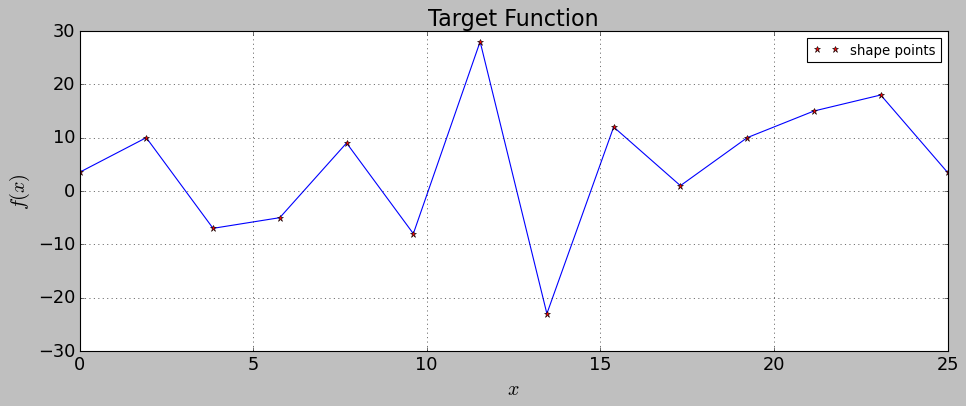

In [4]:
'''Generate the scaffolding of the manufactured solution'''

from engy_5310.toolkit import TargetFunction   
import numpy as np

shape_pts_y = [u_a_0,10,-7,-5,9,-8,28,-23,12,1,10,15,18,u_b_0]
shape_pts_x = [x for x in np.linspace(x_a, x_b, len(shape_pts_y))]
shape_pts = list(zip(shape_pts_x, shape_pts_y))

f = TargetFunction(shape_pts, type='linear')
      
f.plot(n_plot_pts=300, show_shape_pts=True, title='Target Function')

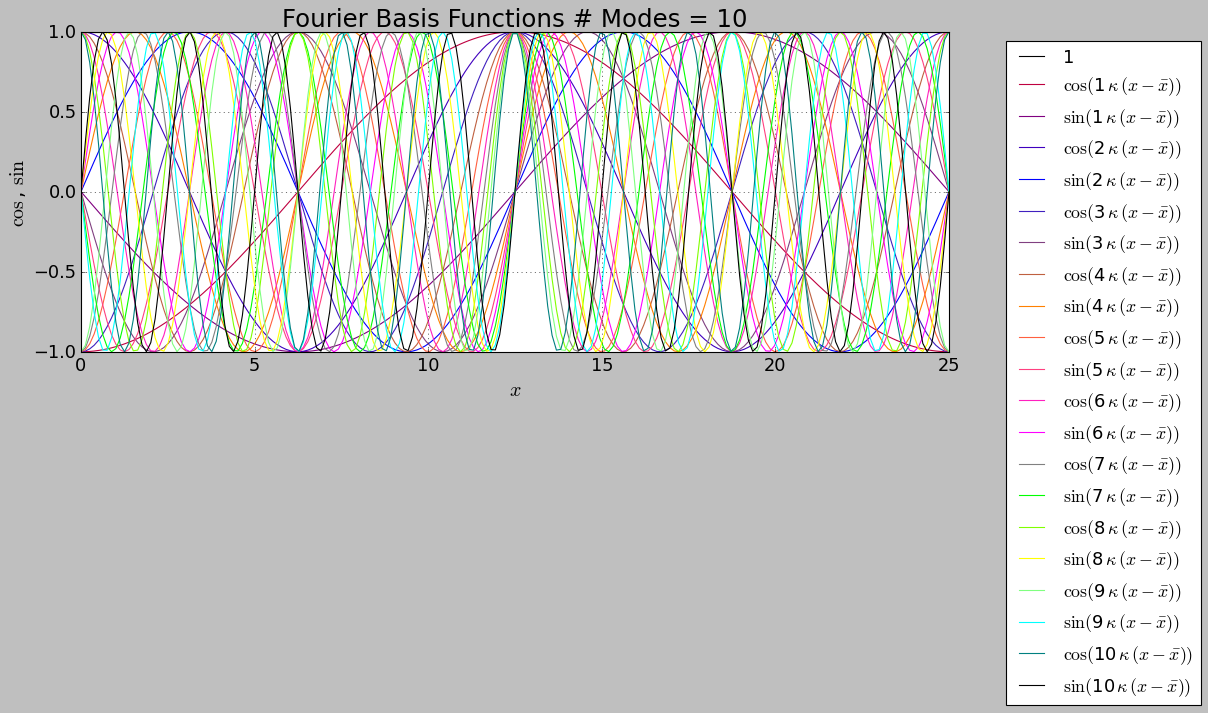

In [5]:
'''Build the basis functions list'''

import math

wavelength = x_b - x_a
kappa = 2*math.pi/wavelength

N = 10 # number of pairs of sine/cosine

try:    
    from engy_5310.toolkit import FourierBasis  
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

fb = FourierBasis(kappa, N, x_a, x_b)
fb.plot()

In [6]:
'''Build the Gram matrix'''

gram_mtrx = fb.gram_matrix(constrain_end_points=True)

#np.set_printoptions(precision=1, threshold=1000, edgeitems=20, linewidth=200)
#print(gram_mtrx)

if gram_mtrx.shape[0] > gram_mtrx.shape[1]:
    print('G is overdetermined.')
elif gram_mtrx.shape[0] < gram_mtrx.shape[1]:
    print('G is underdetermined.')  
else:
    print('G is determined.')

try:    
    from engy_5310.toolkit import matrix_rank
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'
    
if matrix_rank(gram_mtrx) == min(gram_mtrx.shape):
    print('G is full rank.')
else:
    print('G is rank deficient.')

G is determined.
G is full rank.


In [8]:
'''Build load vector'''

b_vec = np.zeros(len(fb.basis_func_list), dtype=np.float64)

for i, phi_i in enumerate(fb.basis_func_list):
    (b_vec[i], _) = fb.inner_product(f, phi_i, epsabs=1e-3, epsrel=1.e-3, limit=1500) \
                  + f.values(x_a)*phi_i(x_a) + f.values(x_b)*phi_i(x_b)               

In [9]:
'''Compute optimal coefficient vector'''

beta_vec = np.linalg.solve(gram_mtrx, b_vec)

### [Manufactured Function](#toc)<a id="manufactured-function"></a>

In [10]:
'''Build the best approximant function'''

def u_manufactured(x):
    return fb.evaluation_matrix(x)@beta_vec

def u_prime_manufactured(x):
    return fb.evaluation_matrix(x, derivative=True)@beta_vec

def diff_flux_x_manufactured(x):
    return -diff_coeff*u_prime_manufactured(x)

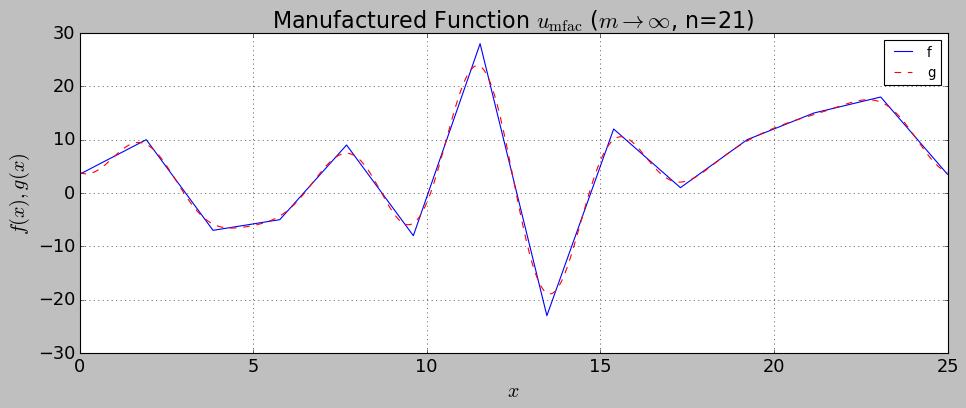

In [11]:
'''Plot comparison of f and g_best_vec'''

n_pts = 300
x_pts = np.linspace(x_a, x_b, n_pts)

u = u_manufactured(x_pts)

f.plot(g=(x_pts,u), n_plot_pts=n_pts, title=r'Manufactured Function $u_\mathrm{mfac}$ ($m\rightarrow\infty$, n='+str(len(fb.basis_func_list))+')')

In [12]:
print('u_mfac(x_a) = ', u_manufactured(x_a), '; u_a_0 = ', u_a_0)
print('u_mfac(x_b) = ', u_manufactured(x_b), '; u_b_0 = ', u_b_0)

u_mfac(x_a) =  [3.8449365] ; u_a_0 =  3.5
u_mfac(x_b) =  [3.8449365] ; u_b_0 =  3.5


In [13]:
print("u'_mfac(x_a) = ", u_prime_manufactured(x_a))
print("u'_mfac(x_b) = ", u_prime_manufactured(x_b))

u'_mfac(x_a) =  [-2.60050322]
u'_mfac(x_b) =  [-2.60050322]


In [14]:
'''Update Boundary Condition Values'''

u_a = u_manufactured(x_a)
u_b = u_manufactured(x_b)

### [Manufactured Source](#toc)<a id="manufactured-source"></a>

In [15]:
'''Build the best approximant function'''

def u_prime2_manufactured(x):
    return fb.evaluation_matrix(x, derivative_2=True)@beta_vec

In [16]:
'''Build the best approximant function'''

def source_bias(x):
    return -diff_coeff * u_prime2_manufactured(x) - source_slope_value * u_manufactured(x)

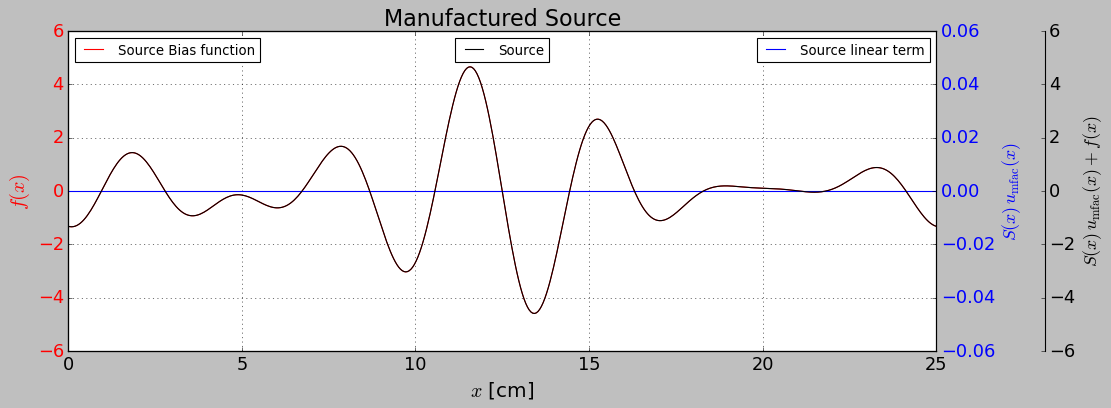

In [17]:
'''Source function'''

n_pts = 500
x = np.linspace(x_a, x_b, n_pts)
f_values = source_bias(x)
s_u_values = source_slope_value * u_manufactured(x)

import matplotlib.pyplot as plt
#%matplotlib inline
#plt.style.use('dark_background')
(fig, ax1) = plt.subplots(1, figsize=(14, 5))

ax1.plot(x, f_values, 'r-', label='Source Bias function')
ax1.set_xlabel(r'$x$ [cm]', fontsize=18)
ax1.set_ylabel(r'$f(x)$', fontsize=18, color='red')
ax1.tick_params(axis='y', labelcolor='red', labelsize=16)
ax1.tick_params(axis='x', labelsize=16)
ax1.legend(loc='upper left', fontsize=12)
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(x, s_u_values,'-', color='blue', label='Source linear term')
ax2.set_ylabel(r"$S(x)\, u_\mathrm{mfac}(x)$", fontsize=16, color='blue')
ax2.tick_params(axis='y', labelcolor='blue', labelsize=16)
ax2.legend(loc='upper right', fontsize=12)

ax3 = ax1.twinx()
ax3.plot(x, s_u_values+f_values,'-', color='black', label='Source')
ax3.set_ylabel(r"$S(x)\, u_\mathrm{mfac}(x) + f(x)$", fontsize=16, color='black')
ax3.tick_params(axis='y', labelcolor='black', labelsize=16)
ax3.legend(loc='upper center', fontsize=12)
ax3.spines["right"].set_position(("axes", 1.125))

plt.title(r'Manufactured Source', fontsize=20)
plt.show()

In [18]:
'''Source bias evaluated at the boundaries'''

np.set_printoptions(precision=5)
print('f(x_a) = ',source_bias(x_a), '   f(x_b) = ',source_bias(x_b))

f(x_a) =  [-1.32367]    f(x_b) =  [-1.32367]


## [Rayleigh-Ritz Method w/ Lagrange Finite Element Basis Functions](#toc)<a id="rayleigh-ritz-fem"></a>

Find $u^*_N \in V_N(a,b)\subset V(a,b) = \bigl\{ u:[a,b]\subset\Reals\rightarrow\Reals  \bigr\}$ such that it minimizes the constrained Poisson energy norm:

\begin{equation*}
  \norm{u_0+w-u^*_N}^2_{\Ecal} = \min\limits_{u_N\, \in\, V_N} \norm{u_0+w-u_N}^2_{\Ecal},
\end{equation*}

where 
$V_N(a,b) := \bigl\{ u_N = \sum\limits_{i=1}^N\,c_i\,\phi_i \mid u_N(a) = u_N(b) = 0, (u'_N,u'_N) < \infty \bigr\}$, $\{\phi_i\mid i=1\ldots,N\}$ is a basis of $V_N(a,b)$, and any $w \in V$ with $w(a) = u_a$, $w(b) = u_b$ is called the *lift* function. $u_0 \in V(a,b)$ is the solution of the homogeneous problem.

The optimum coefficients $\cvec^* := \{c_i\mid i=1,\ldots,N\}$ solve

\begin{equation*}
 \overset{(N\times N)}{\Amtrx}\,\overset{(N\times 1)}{\cvec^*} = \overset{(N\times 1)}\bvec ,
\end{equation*}

where:
  + $A_{i,j} = (D\,\phi'_i,\phi'_j) + (S\,\phi_i,\phi_j)$
  + $b_i = (f,\phi_i) - (D\,w',\phi'_i) + (S\,w,\phi_i)$
  
This formulation uses basis functions that satisfy homogeneous boundary conditions, however the linear algebraic problem for the optimum coefficients accounts for the inhomogeneous boundary condition data through the lift function $w$.

### [Lift Function](#toc)<a id="lift-function"></a>
Since $w\in V(a,b)$, construct as follows $w = \sum\limits_{i=1}^N\,\alpha_i\,\phi_i$ such that $w(a) = u_a$ and $w(b) = u_b$.

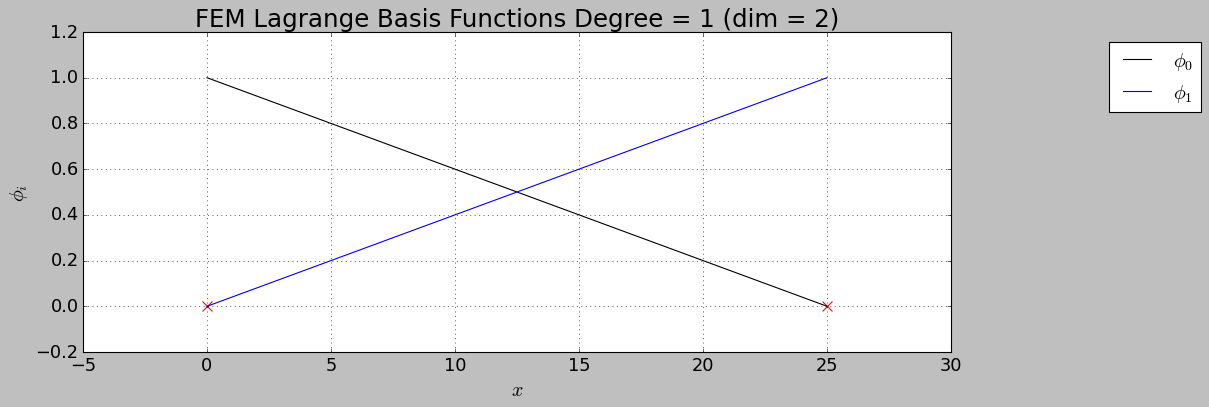

In [19]:
'''Build the lift basis functions'''

degree = 1

try:    
    from engy_5310.toolkit import FEMBasis  
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

lift_basis = FEMBasis(degree=degree, n_elem=1, x_partition=[x_a, x_b])
lift_basis.plot(n_plot_pts=300)

In [20]:
'''Build the coefficients of the lift function'''

alpha_vec = np.zeros(len(lift_basis.basis_func_list))
alpha_vec[0] = u_a
if degree == 2:
   alpha_vec[-2] = u_b
else:
   alpha_vec[-1] = u_b

In [21]:
'''Build the lift function'''

def w_lift(x):
    return lift_basis.evaluation_matrix(x)@alpha_vec

In [22]:
'''Build the lift function derivative'''

def w_lift_prime(x):
    return lift_basis.evaluation_matrix(x, derivative=True)@alpha_vec

In [23]:
'''Test boundary values'''

print('w(a) = ',w_lift(x_a), ' w(b) = ', w_lift(x_b))

w(a) =  [3.84494]  w(b) =  [3.84494]


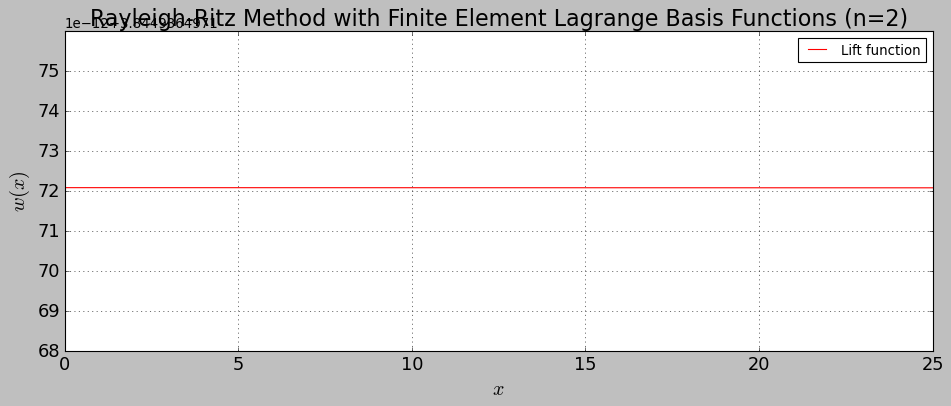

In [24]:
'''Rayleigh Ritz Method with Lagrange Basis Functions'''

n_pts = 500
x = np.linspace(x_a, x_b, n_pts)
u_values = w_lift(x)

import matplotlib.pyplot as plt
#%matplotlib inline
#plt.style.use('dark_background')
plt.figure(1, figsize=(14, 5))

plt.plot(x, u_values, 'r-', label='Lift function')

plt.title(r'Rayleigh-Ritz Method with Finite Element Lagrange Basis Functions (n='+str(len(lift_basis.basis_func_list))+')', fontsize=20)
plt.ylabel(r'$w(x)$', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best',fontsize=12)
plt.grid(True)
plt.show()

### [Finite Element Lagrange Basis Functions](#toc)<a id="fem-lagrange-basis-inhomogeneous"></a>

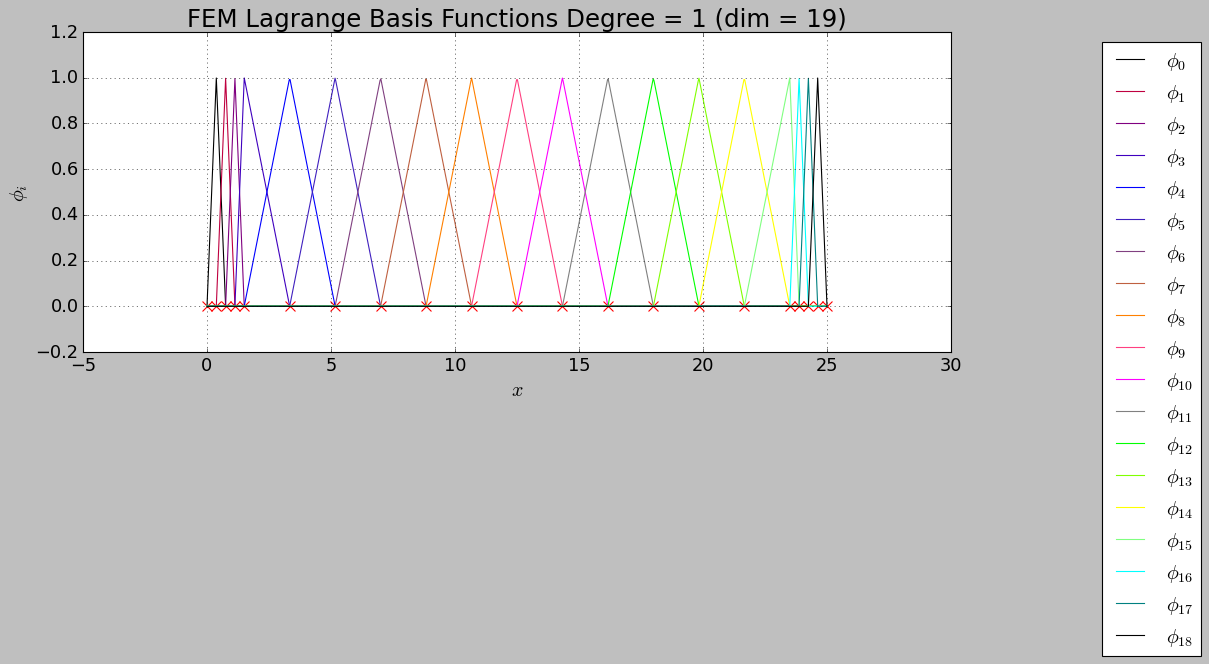

In [47]:
'''Build the basis functions'''

degree = 1

try:    
    from engy_5310.toolkit import FEMBasis  
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'
    
femlb = FEMBasis(degree=degree, n_elem=[4,12,4], x_partition=[x_a, x_a+1.5, x_b-1.5, x_b], bc_x_min='dirichlet', bc_x_max='dirichlet')
femlb.plot(n_plot_pts=800)

In [48]:
'''Build the matrix of coefficients of the linear system'''

import numpy as np
n = len(femlb.basis_func_list)
a_mtrx = np.zeros((n, n), dtype=np.float64)
  
for i,phi_prime_i in enumerate(femlb.basis_func_prime_list):
    for j,phi_prime_j in enumerate(femlb.basis_func_prime_list):
        (a_ij, _) = femlb.inner_product(phi_prime_j, phi_prime_i)
        a_mtrx[i,j] = a_ij * diff_coeff
        
for i,phi_i in enumerate(femlb.basis_func_list):
    for j,phi_j in enumerate(femlb.basis_func_list):
        s_x_phi_j = lambda x: source_slope_value * phi_j(x)
        (a_ij, _) = femlb.inner_product(s_x_phi_j, phi_i)
        a_mtrx[i,j] += a_ij

In [49]:
try:    
    from engy_5310.toolkit import matrix_rank
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'
    
if matrix_rank(a_mtrx) == min(a_mtrx.shape):
    print('A is full rank.')
else:
    print('A is rank deficient.')

A is full rank.


In [38]:
'''Build load vector'''

b_vec = np.zeros(n, dtype=np.float64)

for i, phi_i in enumerate(femlb.basis_func_list):
    (b_vec[i], _) = femlb.inner_product(source_bias, phi_i)
    d_x_w_lift_prime = lambda x: diff_coeff * w_lift_prime(x)
    (term1, _) = femlb.inner_product(d_x_w_lift_prime, femlb.basis_func_prime_list[i])
    b_vec[i] -= term1
    s_x_w = lambda x: source_slope_value * w_lift(x)
    (term2, _) = femlb.inner_product(s_x_w, phi_i)
    b_vec[i] +=  term2

In [39]:
'''Compute optimal coefficient vector'''

c_star_vec = np.linalg.solve(a_mtrx, b_vec)

### [FEM Solution](#toc)<a id="results"></a>

In [40]:
'''Build the best approximation function in V_N'''

def u_star(x):
    u_0 = femlb.evaluation_matrix(x)@c_star_vec
    w = lift_basis.evaluation_matrix(x)@alpha_vec
    return u_0 + w

In [41]:
'''Build the best approximation function derivative in V_N'''

def u_prime_star(x):
    u_0 = femlb.evaluation_matrix(x, derivative=True)@c_star_vec
    w = lift_basis.evaluation_matrix(x, derivative=True)@alpha_vec
    return u_0 + w

In [42]:
def diff_flux_x_star(x):
    return -diff_coeff*u_prime_star(x)

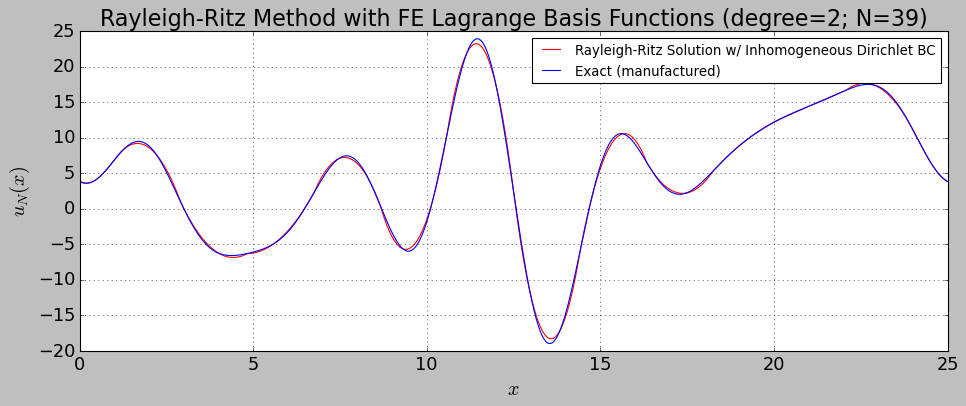

In [43]:
'''Rayleigh Ritz Method with Fourier Basis Functions'''

n_pts = 800
x = np.linspace(x_a, x_b, n_pts)
u_values = u_star(x)
u_exact_values = u_manufactured(x)

import matplotlib.pyplot as plt
#%matplotlib inline
#plt.style.use('dark_background')
plt.figure(1, figsize=(14, 5))

plt.plot(x, u_values, 'r-', label='Rayleigh-Ritz Solution w/ Inhomogeneous Dirichlet BC')
plt.plot(x, u_exact_values, 'b-', label='Exact (manufactured)')

plt.title(r'Rayleigh-Ritz Method with FE Lagrange Basis Functions (degree='+str(degree)+'; N='+str(len(femlb.basis_func_list))+')', fontsize=20)
plt.ylabel(r'$u_N(x)$', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best',fontsize=12)
plt.grid(True)
plt.show()

In [44]:
'''L2 norm relative error'''

from scipy.integrate import quad
import math

def u_exact_2_integrand(x):
    u_exact = u_manufactured(x)
    return u_exact**2

u_exact_2_integral, error = quad(u_exact_2_integrand, x_a, x_b, limit=1000)
print('||u_mfac||_L2 =', math.sqrt(u_exact_2_integral))
#print('quadrature error =', error)

def u_minus_u_exact_2_integrand(x):
    u_x = u_star(x)
    u_exact_x = u_manufactured(x)
    return (u_x-u_exact_x)**2

print('')

u_minus_u_exact_2_integral, error = quad(u_minus_u_exact_2_integrand, x_a, x_b, limit=1000)
print('||u-u_mfac||_L2 =', math.sqrt(u_minus_u_exact_2_integral))
#print('quadrature error =', error)

print('')
print('Relative error [%] =', math.sqrt(u_minus_u_exact_2_integral)/math.sqrt(u_exact_2_integral)*100)

||u_mfac||_L2 = 51.19407408360285

||u-u_mfac||_L2 = 1.356662214217695

Relative error [%] = 2.650037603966014


In [45]:
'''Rayleigh-Ritz solution evaluated at the boundaries'''

np.set_printoptions(precision=5)
print('u_N(a) = ',u_star(x_a), '  u_N(b) = ',u_star(x_b))

u_N(a) =  [3.84494]   u_N(b) =  [3.84494]


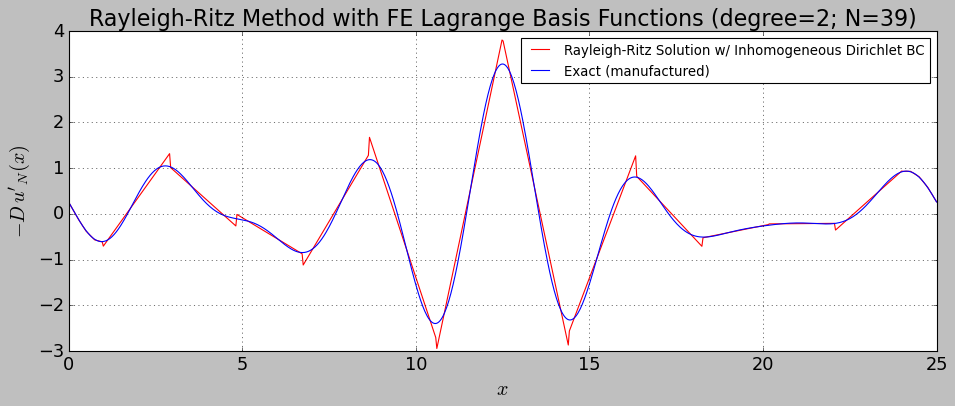

In [46]:
'''Rayleigh Ritz Method with Fourier Basis Functions'''

n_pts = 800
x = np.linspace(x_a, x_b, n_pts)
diff_flux_x_values = diff_flux_x_star(x)
diff_flux_x_exact_values = diff_flux_x_manufactured(x)

import matplotlib.pyplot as plt
#%matplotlib inline
#plt.style.use('dark_background')
plt.figure(1, figsize=(14, 5))

plt.plot(x, diff_flux_x_values, 'r-', label='Rayleigh-Ritz Solution w/ Inhomogeneous Dirichlet BC')
plt.plot(x, diff_flux_x_exact_values, 'b-', label='Exact (manufactured)')

plt.title(r'Rayleigh-Ritz Method with FE Lagrange Basis Functions (degree='+str(degree)+'; N='+str(len(femlb.basis_func_list))+')', fontsize=20)
plt.ylabel(r"$-D\,u'_N(x)$", fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best',fontsize=12)
plt.grid(True)
plt.show()

In [ ]:
'''L2 norm relative error'''

from scipy.integrate import quad
import math

def u_prime_exact_2_integrand(x):
    u_prime_exact = u_prime_manufactured(x)
    return u_prime_exact**2

u_prime_exact_2_integral, error = quad(u_prime_exact_2_integrand, x_a, x_b, limit=1000)
print("||u'_mfac||_L2 =", math.sqrt(u_prime_exact_2_integral))
#print('quadrature error =', error)

def u_prime_minus_u_prime_exact_2_integrand(x):
    u_prime_x = u_prime_star(x)
    u_prime_exact_x = u_prime_manufactured(x)
    return (u_prime_x-u_prime_exact_x)**2

print('')

u_prime_minus_u_prime_exact_2_integral, error = quad(u_prime_minus_u_prime_exact_2_integrand, x_a, x_b, limit=1000)
print("||u'-u'_mfac||_L2 =", math.sqrt(u_prime_minus_u_prime_exact_2_integral))
#print('quadrature error =', error)

print('')
print('Relative error [%] =', math.sqrt(u_prime_minus_u_prime_exact_2_integral)/math.sqrt(u_prime_exact_2_integral)*100)

In [ ]:
'''Rayleigh-Ritz solution evaluated at the boundaries'''

np.set_printoptions(precision=5)
print("u'_N(a) = ", u_prime_star(x_a), "  u'_N(b) = ", u_prime_star(x_b))
print("u'_mfac(a) = ", u_prime_manufactured(x_a), "  u'_mfac(b) = ", u_prime_manufactured(x_b))